🌿Preprocessing

In [1]:
subset_size_per_digit = 1000
n_components = 20
d = 2

In [2]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pickle

# load local mnist data file
mnist_path = "/home/ajay2425/rclass/mnist_dataset/mnist.npz"
with np.load(mnist_path) as data:
    x_train = data["x_train"]
    y_train = data["y_train"]
print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}")

# 1. Flatten
x_train_flat = x_train.reshape(x_train.shape[0], -1)
print(f"1. x_train_flat shape: {x_train_flat.shape}, y_train shape: {y_train.shape}")

# 2. Subsets (with equal distribution)
# subset_size_per_digit = 350
unique_digits = np.unique(y_train)

x_train_balanced = []
y_train_balanced = []

for digit in unique_digits:
    # Get indices of all samples of the current digit
    digit_indices = np.where(y_train == digit)[0]
    # Randomly sample subset_size_per_digit indices
    sampled_indices = np.random.choice(digit_indices, subset_size_per_digit, replace=False)
    # Append the sampled data
    x_train_balanced.append(x_train_flat[sampled_indices])
    y_train_balanced.append(y_train[sampled_indices])

# Combine and shuffle the balanced dataset
x_train_balanced = np.vstack(x_train_balanced)
y_train_balanced = np.hstack(y_train_balanced)

# Shuffle the dataset
shuffled_indices = np.random.permutation(len(y_train_balanced))
x_train_subset = x_train_balanced[shuffled_indices]
y_train_subset = y_train_balanced[shuffled_indices]
print(f"2. x_train_subset shape: {x_train_subset.shape}")

# 3. PCA
# n_components = 19
# d = 2 # degree
pca = PCA(n_components=n_components)
x_train_pca = pca.fit_transform(x_train_subset)
print(f"3. x_train_pca shape: {x_train_pca.shape}")
variance = np.sum(pca.explained_variance_ratio_)
print(f"variance = {variance*100}%")

# Save the trained PCA model
pca_model_path = "/home/ajay2425/rclass/models/models_grb/trained_pca.pkl"
with open(pca_model_path, "wb") as file:
    pickle.dump(pca, file)

x_train_norm = x_train_pca

# # 4. Normalize
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler(feature_range=(0, 1))
# x_train_norm = scaler.fit_transform(x_train_pca)
# print(f"4. x_train_norm shape: {x_train_norm.shape}")

# # 4. Binarize
# threshold_value = 0
# x_train_norm = (x_train_pca > threshold_value).astype(int)
# print(f"4. x_train_norm shape: {x_train_norm.shape}")
# # print(x_train_norm)

x_train shape: (60000, 28, 28), y_train shape: (60000,)
1. x_train_flat shape: (60000, 784), y_train shape: (60000,)
2. x_train_subset shape: (10000, 784)
3. x_train_pca shape: (10000, 20)
variance = 64.13435703386689%


🌿Check Directory

In [3]:
import os

# Path to the directory
models_dir = "/home/ajay2425/rclass/models/models_grb/"
print(f"Using existing directory: {models_dir}")

# Check if the directory exists
if os.path.exists(models_dir):
    print("Directory already exists.")
else:
    print("Directory does not exist!")

Using existing directory: /home/ajay2425/rclass/models/models_grb/
Directory already exists.


🌿Generate multi-Indices

In [4]:
def r_multi_indices(n, d):
    if n == 1:
        yield (d,)
    else:
        for k in range(d + 1):
            for c in r_multi_indices(n - 1, k):
                yield (d - k, *c)

def generate_multi_indices(n, d):
    from itertools import chain
    return list(chain(*[list(r_multi_indices(n, _)) for _ in range(d + 1)]))

c = generate_multi_indices(n_components, d)
print(f"no_of_coeff =", len(c))

no_of_coeff = 231


🌿Generate Polynomials

In [5]:
import numpy as np

def construct_G_H_matrices(x_train_norm, n, d):
    num_data_points = x_train_norm.shape[0]
    multi_indices = generate_multi_indices(n, d)
    num_coefficients = len(multi_indices)

    # Initialize G and H matrices
    G = []
    H = []

    # Construct G and H using multi-indices
    for i in range(num_data_points):
        G_row = []
        H_row = []
        for idx in multi_indices:
            term = np.prod([x_train_norm[i, k] ** idx[k] for k in range(n)])
            G_row.append(term)
            H_row.append(term)
        G.append(G_row)
        H.append(H_row)

    # Convert G and H to NumPy arrays
    G = np.array(G)
    H = np.array(H)

    # Normalize G and H row-wise for numerical stability
    G = G / np.linalg.norm(G, axis=1, keepdims=True)
    H = H / np.linalg.norm(H, axis=1, keepdims=True)

    return G, H, multi_indices

🌿Problem Setup

In [6]:
from gurobipy import Model, GRB, Env

# Suppress Gurobi logs globally
env = Env(empty=True)
env.setParam("OutputFlag", 0)  # Suppress Gurobi logs
env.start()

# Initialize the Gurobi model with suppressed logs
model = Model("Rational_Function_Optimization", env=env)
multi_indices = generate_multi_indices(n_components, d)
num_coefficients = len(multi_indices)

🌿Feasibility Check

In [7]:
from gurobipy import Model, GRB, quicksum
import numpy as np

def check_feasibility(z, x_train_norm, y_binary, G, H, num_coefficients):

    delta = 1e-6  # Threshold for positivity constraint
    n_samples = x_train_norm.shape[0]

    # Initialize Gurobi model
    model = Model("constraints")
    model.setParam("OutputFlag", 0)  # Suppress Gurobi logs
    # model.setParam("Seed", 42)  # Fix solver seed for consistency
    # model.setParam("Threads", 1)  # Disable multi-threading for consistency

    # Define variables
    alpha = model.addVars(num_coefficients, lb=-GRB.INFINITY, name="alpha")
    beta = model.addVars(num_coefficients, lb=-GRB.INFINITY, name="beta")
    theta = model.addVar(lb=0, name="theta")
    intermediate_vars = model.addVars(n_samples, 3, lb=-GRB.INFINITY, name="intermediate")

    # Add constraints for each sample
    for i in range(n_samples):
        # Auxiliary variables for linearization
        G_x = quicksum(alpha[j] * G[i, j] for j in range(num_coefficients))  # αᵀG(xᵢ)
        H_x = quicksum(beta[j] * H[i, j] for j in range(num_coefficients))   # βᵀH(xᵢ)
        f_x = y_binary[i]  # Binary label for the sample

        # Define intermediate variables to simplify nonlinear terms
        model.addConstr(intermediate_vars[i, 0] == (f_x - z) * H_x, name=f"term1_sample_{i}")  # (f(xᵢ) - z)·βᵀH(xᵢ)
        model.addConstr(intermediate_vars[i, 1] == (-(f_x + z)) * H_x, name=f"term2_sample_{i}")  # (-(f(xᵢ) + z))·βᵀH(xᵢ)
        model.addConstr(intermediate_vars[i, 2] == H_x, name=f"positivity_term_sample_{i}")  # βᵀH(xᵢ)

        # Constraint 1: (f(xᵢ) - z)·βᵀH(xᵢ) - αᵀG(xᵢ) ≤ θ
        model.addConstr(intermediate_vars[i, 0] - G_x <= theta, name=f"upper_bound_sample_{i}")

        # Constraint 2: αᵀG(xᵢ) + (-(f(xᵢ) + z))·βᵀH(xᵢ) ≤ θ
        model.addConstr(G_x + intermediate_vars[i, 1] <= theta, name=f"lower_bound_sample_{i}")

        # Constraint 3: βᵀH(xᵢ) ≥ δ
        model.addConstr(intermediate_vars[i, 2] >= delta, name=f"positivity_sample_{i}")

    # Set objective
    model.setObjective(theta, GRB.MINIMIZE)

    # Solve the model
    model.optimize()

    # Extract results
    if model.status == GRB.OPTIMAL:
        optimal_alpha = [alpha[j].X for j in range(num_coefficients)]
        optimal_beta = [beta[j].X for j in range(num_coefficients)]
        optimal_theta = theta.X
        # print(f"Optimal solution found: Theta = {optimal_theta}")
        return True, optimal_alpha, optimal_beta, optimal_theta
    else:
        # print(f"Model not feasible or no solution found. Status: {model.status}")
        return False, None, None, None

🌿Bisection Loop

In [8]:
def bisection_loop(x_train_norm, y_binary, uL, uH, precision, model, num_coefficients, G, H, delta):
    z_values = []
    optimal_alpha, optimal_beta, optimal_theta = None, None, None
    
    # print("Starting bisection loop...")
    # print(f"Initial bounds: uL={uL}, uH={uH}, precision={precision}")

    while uH - uL > precision:
        z = (uL + uH) / 2  # Midpoint of bounds
        z_values.append(z)
        # print(f"Testing z = {z}...")

        # Feasibility Check
        feasible, alpha_coefficients, beta_coefficients, theta = check_feasibility(
            z, x_train_norm, y_binary, G, H, num_coefficients
        )

        if feasible:
            # print(f"z = {z} is feasible.")
            uH = z
            optimal_alpha, optimal_beta, optimal_theta = alpha_coefficients, beta_coefficients, theta
        else:
            # print(f"z = {z} is not feasible.")
            uL = z

    # print("Bisection loop completed.")
    # print(f"Optimal z: {uH}")
    # print(f"Optimal theta: {optimal_theta}")
    return uH, optimal_alpha, optimal_beta, optimal_theta, z_values

🌿Train (one-vs-all) - multiprocessing 

In [9]:
from multiprocessing import Pool, cpu_count
from sklearn.metrics import accuracy_score
import time
from sklearn.preprocessing import LabelBinarizer
import pickle
from gurobipy import *

# Function to train a single classifier for one digit
def train_classifier(digit):
    # print(f"Training classifier for digit {digit}...")

    # current digit=1, other digits=0
    y_binary = np.where(y_binarized[:, digit] == 1, 1, 0)
    # y_binary = np.where(y_binarized[:, digit] == 1, 0.1, -0.1)

    # Construct G and H matrices for the training data
    G, H, multi_indices = construct_G_H_matrices(x_train_norm, n_components, d)

    # Initialize the Gurobi model
    model = Model(f"digit_{digit}_classifier")
    model.setParam('OutputFlag', 0)  # Suppress Gurobi logs
    # model.setParam('Threads', 10)     # restricting each Gurobi instance to a single thread

    # Run bisection loop to find optimal coefficients
    optimal_z, optimal_alpha, optimal_beta, optimal_theta, z_values = bisection_loop(
        x_train_norm, y_binary, uL, uH, precision, model, len(multi_indices), G, H, delta
    )

    # Check if a feasible solution was found
    if optimal_alpha is None or optimal_beta is None or optimal_theta is None:
        print(f"No feasible solution found for digit {digit}. Skipping...")
        return None

    # Save the model parameters
    model_data = {
        "alpha": optimal_alpha,
        "beta": optimal_beta,
        "theta": optimal_theta,
        "z": optimal_z,
        "n_components": n_components,
        "degree": d,
        "multi_indices": multi_indices
    }
    model_path = f"{models_dir}/classifier_{digit}.pkl"
    with open(model_path, "wb") as file:
        pickle.dump(model_data, file)

    return digit

# training logic
if __name__ == "__main__":

    training_start_time = time.time()

    # Binarize the labels for one-vs-all classification
    lb = LabelBinarizer()
    y_binarized = lb.fit_transform(y_train_subset)

    # Define bisection parameters
    uL = 0  # Lower bound
    uH = 10  # Upper bound
    precision = 1e-8  # Precision for bisection loop
    delta = 1e-6  # Threshold for positivity constraint

    # Number of cores to use for parallel training
    num_cores = min(cpu_count(), 10)
    print(f"Using {num_cores} cores for parallel training")

    # Train classifiers for digits (0–9) in parallel
    with Pool(num_cores) as pool:
        results = pool.map(train_classifier, range(10))

    # Stop timer for training
    training_time = time.time() - training_start_time
    print(f"Training Time: {training_time:.2f} seconds")

    #------------------------------------------------------
    # Calculate individual training accuracy for each classifier
    individual_accuracies = []
    for digit in range(10):
        model_path = f"{models_dir}/classifier_{digit}.pkl"
        if not os.path.exists(model_path):
            print(f"Model for digit {digit} not found. Skipping...")
            continue

        # Load the model for the current digit
        with open(model_path, "rb") as file:
            model = pickle.load(file)

        alpha = model["alpha"]
        beta = model["beta"]
        multi_indices = model["multi_indices"]
        G, H, _ = construct_G_H_matrices(x_train_norm, model["n_components"], model["degree"])

        # Predictions for training data
        predictions = []
        y_binary = np.where(y_binarized[:, digit] == 1, 1, 0)  # Recreate binary labels
        for i in range(len(x_train_norm)):
            numerator = np.dot(G[i], alpha)
            denominator = np.dot(H[i], beta)
            # if np.abs(denominator) < 1e-8:
            if np.abs(denominator) == 0:
                denominator = 1e-8  # to prevent division by zero
            rational_value = numerator / denominator
            predictions.append(1 if rational_value > 0 else 0)  # Threshold at 0

        # Calculate accuracy
        individual_accuracy = accuracy_score(y_binary, predictions) * 100
        individual_accuracies.append((digit, individual_accuracy))
        print(f"Training Accuracy for Digit {digit}: {individual_accuracy:.2f}%")

    # Calculate overall training accuracy
    overall_predictions = []
    for i in range(len(x_train_norm)):
        confidence_scores = []
        for digit in range(10):
            # Load the model for the current digit
            model_path = f"{models_dir}/classifier_{digit}.pkl"
            with open(model_path, "rb") as file:
                model = pickle.load(file)
            alpha = model["alpha"]
            beta = model["beta"]
            multi_indices = model["multi_indices"]
            G, H, _ = construct_G_H_matrices(np.array([x_train_norm[i]]), model["n_components"], model["degree"])
            numerator = np.dot(G[0], alpha)
            denominator = np.dot(H[0], beta)
            # if np.abs(denominator) < 1e-8:
            if np.abs(denominator) == 0:
                denominator = 1e-8  # to prevent division by zero
            rational_value = numerator / denominator
            confidence_scores.append(rational_value)
        overall_predictions.append(np.argmax(confidence_scores))

    overall_training_accuracy = accuracy_score(y_train_subset, overall_predictions) * 100

    print(f"\nOverall Training Accuracy: {overall_training_accuracy:.2f}%")

Using 10 cores for parallel training
Set parameter Username
Academic license - for non-commercial use only - expires 2026-01-12
Set parameter Username
Academic license - for non-commercial use only - expires 2026-01-12
Set parameter Username
Academic license - for non-commercial use only - expires 2026-01-12
Set parameter Username
Academic license - for non-commercial use only - expires 2026-01-12
Set parameter Username
Academic license - for non-commercial use only - expires 2026-01-12
Set parameter Username
Academic license - for non-commercial use only - expires 2026-01-12
Set parameter Username
Academic license - for non-commercial use only - expires 2026-01-12
Set parameter Username
Academic license - for non-commercial use only - expires 2026-01-12
Set parameter Username
Academic license - for non-commercial use only - expires 2026-01-12
Set parameter Username
Academic license - for non-commercial use only - expires 2026-01-12
Training Time: 4631.45 seconds
Training Accuracy for 

🌿Visual Cross-verification

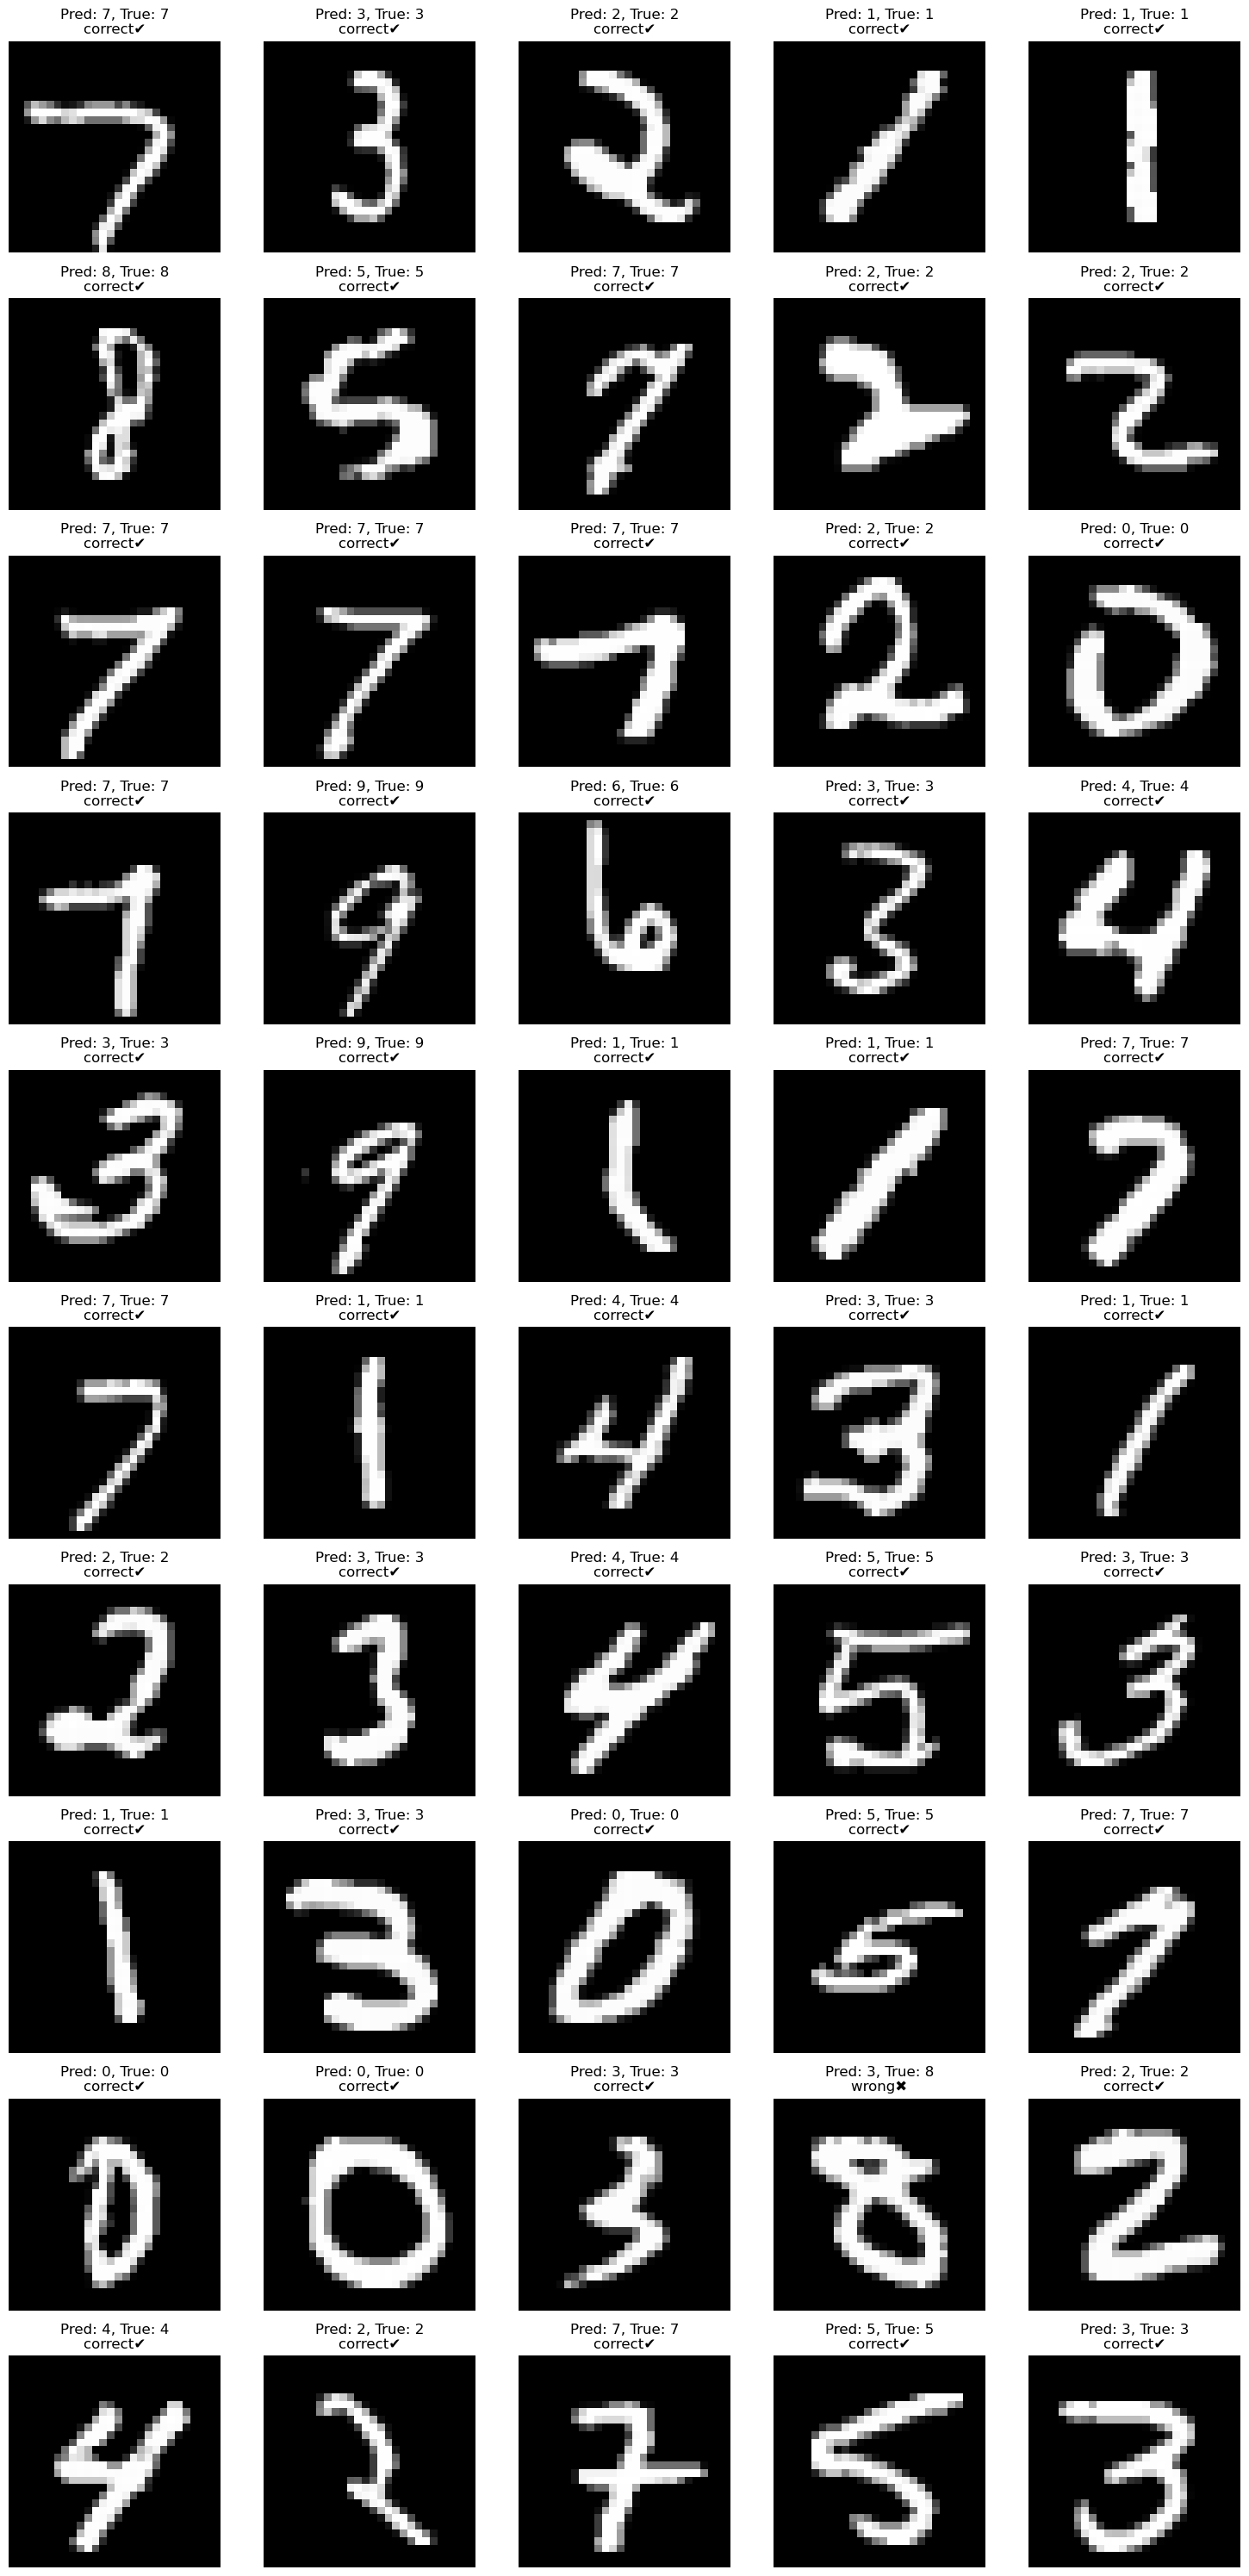

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Specify the range of indices to visualize
start_index = 150
end_index = 200

# Number of rows and columns for the grid
rows = int(np.ceil((end_index - start_index) / 5))  # 5 images per row
cols = 5

# Create a figure
fig, axes = plt.subplots(rows, cols, figsize=(15, 3 * rows))

# Flatten axes array for easier iteration
axes = axes.flatten()

# Iterate through the specified range
for idx, ax in zip(range(start_index, end_index), axes):
    # Predicted and true labels for the current index
    predicted_digit = overall_predictions[idx]
    true_digit = y_train_subset[idx]

    # Reshape the flattened image back to its original shape (28x28)
    image = x_train_subset[idx].reshape(28, 28)

    # Determine correctness
    if predicted_digit == true_digit:
        status = "correct✔️"
    else:
        status = "wrong✖️"
    
    # Plot the image
    ax.imshow(image, cmap='gray')  # Use 'gray' colormap for MNIST
    ax.set_title(f"Pred: {predicted_digit}, True: {true_digit}\n{status}")
    ax.axis("off")  # Hide axes for cleaner visuals

# Turn off unused subplots
for ax in axes[len(range(start_index, end_index)):]:
    ax.axis("off")

# Adjust layout and show the plot
plt.tight_layout()
plt.show()